In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [3]:
#read data
data = pd.read_csv(r'C:\Users\karrt\Downloads\TATAMOTORS.NS.csv', parse_dates=[0], index_col=0, date_parser=parser)

C:\Users\karrt\AppData\Local\Temp\ipykernel_23976\2838551943.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv(r'C:\Users\karrt\Downloads\TATAMOTORS.NS.csv', parse_dates=[0], index_col=0, date_parser=parser)


In [4]:
#infer the frequency of the data
data = data.asfreq(pd.infer_freq(data.index))
# Remove rows with NaN values
data = data.dropna()
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-19,406.50,407.799988,400.100006,400.750000,399.504852,13126520.0
2023-01-20,404.00,412.500000,401.200012,403.149994,401.897400,23906114.0
2023-01-23,407.00,410.950012,405.000000,408.399994,407.131104,13113183.0
2023-01-24,410.00,424.000000,410.000000,422.149994,420.838379,30197475.0
2023-01-25,423.75,427.250000,417.700012,419.049988,417.747986,22975581.0


In [5]:
start_date = datetime(2023,1,19)
end_date = datetime(2023,8,31)
data_train = data[start_date:end_date]

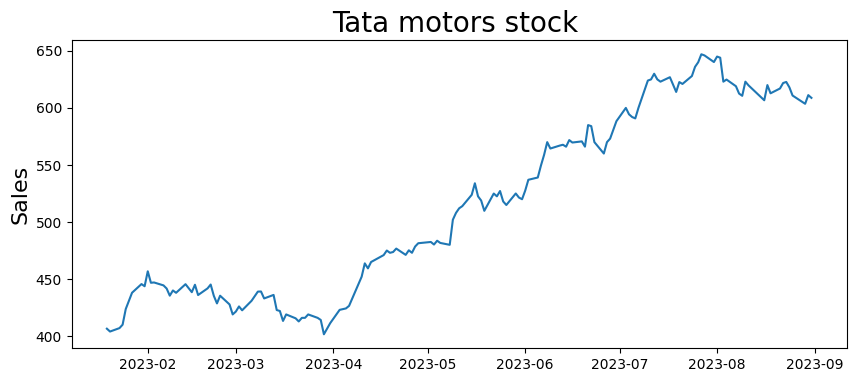

In [6]:
plt.figure(figsize=(10,4))
plt.plot(data_train.index, data_train['Open'])
plt.title('Tata motors stock ', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [7]:
first_diff = data_train.diff()[1:]
first_diff.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-20,-2.50,4.700012,1.100006,2.399994,2.392548,10779594.0
2023-01-23,3.00,-1.549988,3.799988,5.250000,5.233704,-10792931.0
2023-01-24,3.00,13.049988,5.000000,13.750000,13.707275,17084292.0
2023-01-25,13.75,3.250000,7.700012,-3.100006,-3.090393,-7221894.0
2023-01-27,14.25,26.149994,17.449982,26.550018,26.467529,40384886.0


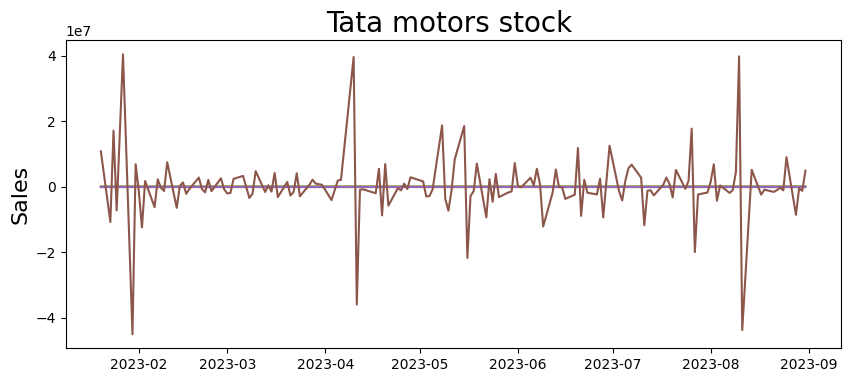

In [8]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Tata motors stock ', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## ACF

<BarContainer object of 20 artists>

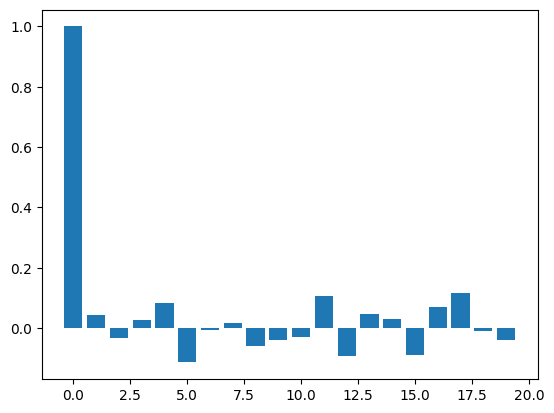

In [9]:
open=first_diff['Open']
acf_vals = acf(open)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

### BASED ON ACF, MA MPROCESS SHOULD HAVE LAG 5

<BarContainer object of 15 artists>

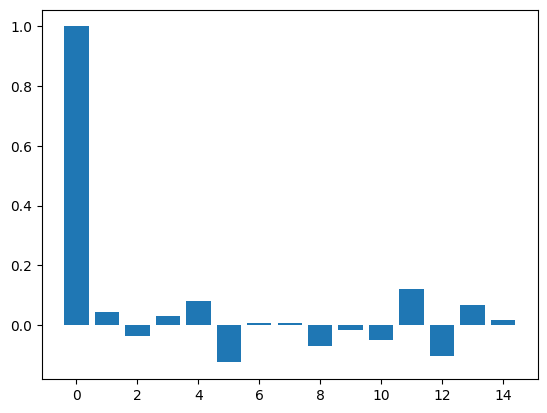

In [10]:
pacf_vals = pacf(open)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

#### BASED ON PACF, AR MODEL SHOULD ALSI HAVE LAG 5.

In [11]:
train_end = datetime(2023,8,31)
test_end = datetime(2024,1,18)

train_data =  data[:train_end]
test_data = data[train_end + timedelta(days=1):test_end]
test_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-01,604.200012,614.900024,601.900024,611.200012,611.200012,10297492.0
2023-09-04,615.599976,615.599976,606.000000,609.000000,609.000000,8392665.0
2023-09-05,610.000000,618.900024,608.049988,611.150024,611.150024,8560651.0
2023-09-06,611.150024,612.549988,605.599976,610.250000,610.250000,6520064.0
2023-09-07,610.900024,616.500000,609.049988,614.900024,614.900024,6520293.0


#### the above gave us training set and testing set, now we'll use ARIMA model


In [12]:
endog_column_name = 'Open'
endog = train_data[endog_column_name]

c:\Users\karrt\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\karrt\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\karrt\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  152
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -521.573
Date:                Mon, 22 Jan 2024   AIC                           1049.145
Time:                        01:28:19   BIC                           1058.197
Sample:                             0   HQIC                          1052.822
                                - 152                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1176      1.170     -0.101      0.920      -2.411       2.176
ma.L1          0.1920      1.161      0.165      0.869      -2.083       2.467
sigma2        58.5758      5.858      9.999      0.0

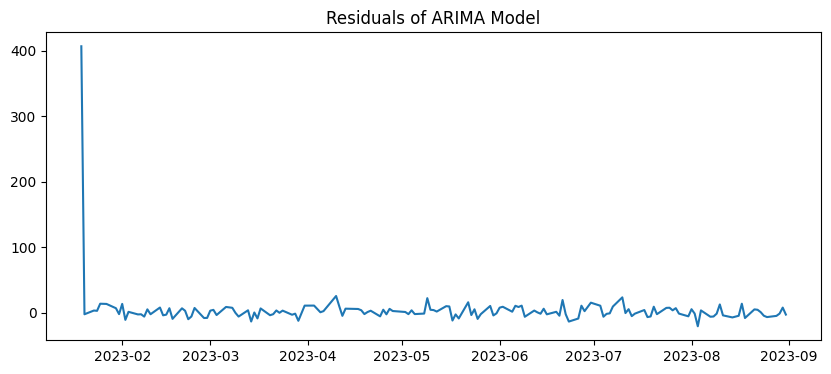

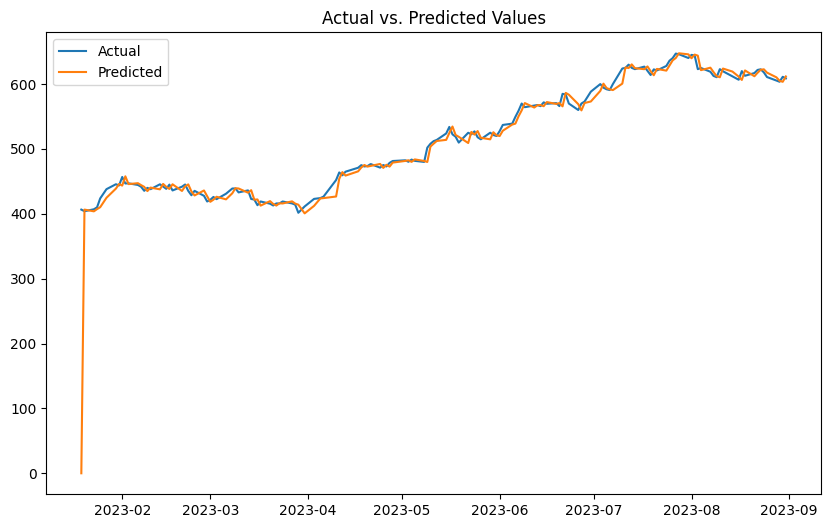

In [13]:
# Fit ARIMA model
order = (1, 1, 1)  # Replace with the order you want (p, d, q)
model = sm.tsa.ARIMA(endog, order=order)
results = model.fit()

# Print model summary
print(results.summary())

# Plot the residuals
residuals = results.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.show()

# Plot the actual vs. predicted values
predictions = results.predict(start=endog.index[0], end=endog.index[-1])
plt.figure(figsize=(10, 6))
plt.plot(endog, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

In [14]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  152
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -521.573
Date:                Mon, 22 Jan 2024   AIC                           1049.145
Time:                        01:28:20   BIC                           1058.197
Sample:                             0   HQIC                          1052.822
                                - 152                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1176      1.170     -0.101      0.920      -2.411       2.176
ma.L1          0.1920      1.161      0.165      0.869      -2.083       2.467
sigma2        58.5758      5.858      9.999      0.0

In [15]:
endog_test=test_data['Open']
endog_test.head()

Date
2023-09-01    604.200012
2023-09-04    615.599976
2023-09-05    610.000000
2023-09-06    611.150024
2023-09-07    610.900024
Name: Open, dtype: float64

In [16]:
residuals.head()

Date
2023-01-19    406.500000
2023-01-20     -2.501755
2023-01-23      3.183620
2023-01-24      2.741712
2023-01-25     13.576444
dtype: float64

c:\Users\karrt\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\karrt\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\karrt\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  152
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -541.597
Date:                Mon, 22 Jan 2024   AIC                           1089.193
Time:                        01:49:38   BIC                           1098.245
Sample:                             0   HQIC                          1092.870
                                - 152                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6800      0.091     -7.481      0.000      -0.858      -0.502
ar.L2         -0.3587      0.078     -4.598      0.000      -0.512      -0.206
sigma2        76.0850      8.295      9.173      0.0

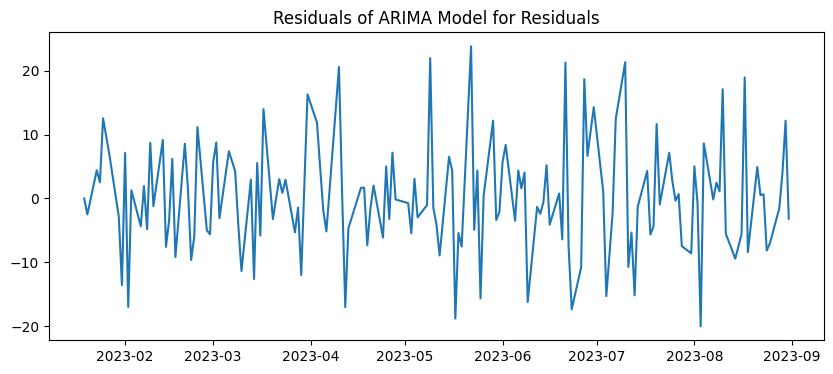

In [56]:
# Fit ARIMA model on residuals
# Replace the first index value of residuals with zero
residuals.iloc[0] = 0  # Assuming residuals_residuals is a pandas Series
residuals_order = (2, 1, 0)  # Replace with the order you want (p, d, q) for residuals
residuals_model = sm.tsa.ARIMA(residuals, order=residuals_order)
residuals_results = residuals_model.fit()

# Print model summary for residuals
print(residuals_results.summary())

# Plot the residuals of the residuals model
residuals_residuals = residuals_results.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals_residuals)
plt.title('Residuals of ARIMA Model for Residuals')
plt.show()

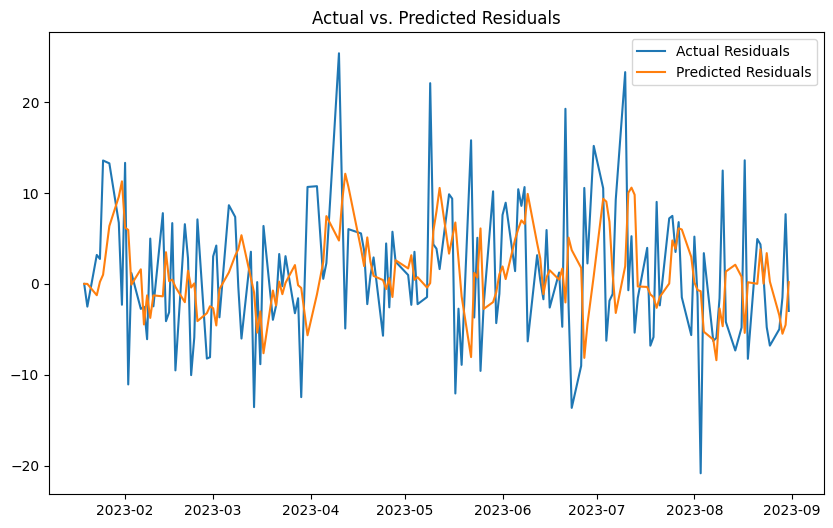

In [57]:
# Plot the actual vs. predicted values for residuals
residuals_predictions = residuals_results.predict(start=residuals.index[0], end=residuals.index[-1])
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Actual Residuals')
plt.plot(residuals_predictions, label='Predicted Residuals')
plt.title('Actual vs. Predicted Residuals')
plt.legend()
plt.show()

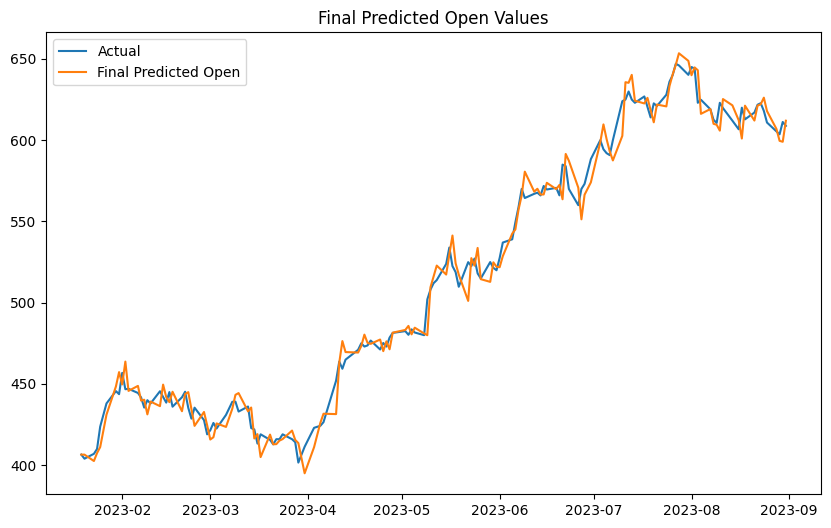

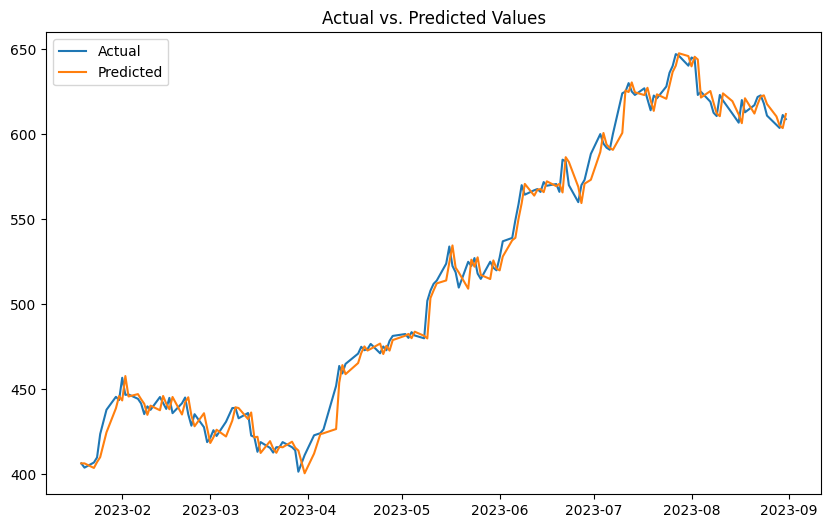

In [58]:
predictions.iloc[0] = endog.iloc[0]

# Combine the predicted residuals with the predicted 'Open' values
final_predictions = predictions + residuals_predictions


# Plot the final predicted 'Open' values
plt.figure(figsize=(10, 6))
plt.plot(endog, label='Actual')
plt.plot(final_predictions, label='Final Predicted Open')
plt.title('Final Predicted Open Values')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(endog, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()